# Домашнее задание 2. Классификация, детекция.

Оценка за часть 1 и часть 2 в этом дз -- по 5 баллов.

## Часть 1. Классификация

В этом задании потребуется обучить классификатор изображений. Будем работать с датасетом, название которого раскрывать не будем. Можете посмотреть самостоятельно на картинки, которые в датасете есть. В нём 200 классов и около 5 тысяч картинок на каждый класс. Классы пронумерованы, как нетрудно догадаться, от 0 до 199. Скачать датасет можно вот [тут](https://yadi.sk/d/BNR41Vu3y0c7qA).

Структура датасета простая -- есть директории train и val, в которых лежат обучающие и валидационные данные. В train/ и val/ лежат директориии, соответствующие классам изображений, в которых лежат собственно сами изображения.
 
__Задание__. Добейтесь accuracy **не менее 0.44**. Напишите краткий отчёт о проделанных экспериментах. Что сработало и что не сработало? Почему вы решили, сделать так, а не иначе? Обязательно указывайте ссылки на чужой код, если вы его используете. Обязательно ссылайтесь на статьи/блогпосты/вопросы на stackoverflow/видосы от (индийских) ютуберов/курсы/подсказки от Дяди Васи и прочие дополнительные материалы, если вы их используете. 

В коде ниже необходимо, чтобы код проходил все `assert`'ы.

Необходимо написать функцию `predict` по шаблону ниже. Эта функция принимает на вход модель, даталоадер с валидационнами данными, criterion для подсчёта лосса и device, на котором будут производиться вычисления (определён ниже) и возвращает список лоссов по всем объектам, список из предсказанных классов для каждого объекта из из даталоалера и список из настоящих классов для каждого объекта в даталоадере (и именно в таком порядке).

__Использовать внешние данные для обучения строго запрещено__. Можно использовать предобученные модели из `torchvision`.

__Критерии оценки__: Оценка вычисляется по простой формуле: min(5, 5 * Ваша accuracy / 0.44). Оценка округляется до десятых по арифметическим правилам.

__Советы и указания__:
 - Наверняка вам потребуется много гуглить о классификации и о том, как заставить её работать. Это нормально, все гуглят. Но не забывайте, что нужно быть готовым за скатанный код отвечать на защите :)
 - Используйте аугментации. Для этого пользуйтесь модулем torchvision.transforms или библиотекой [albumentations](https://github.com/albumentations-team/albumentations)
 - (ещё раз) Можно файнтюнить предобученные модели из `torchvision`.
 - Рекомендуем написать вам сначала класс-датасет (или воспользоваться классом ImageFolder), который возвращает картинки и соответствующие им классы, а затем функции для трейна по шаблонам ниже. Однако делать это мы не заставляем. Если вам так неудобно, то можете писать код в удобном стиле. Однако учтите, что чрезмерное изменение нижеперечисленных шаблонов увеличит количество вопросов к вашему коду и повысит вероятность вызова на защиту :)
 - Валидируйте. Трекайте ошибки как можно раньше, чтобы не тратить время впустую.
 - Чтобы отладить код, пробуйте обучаться на маленькой части датасета. Когда вы поняли, что смогли всё отдебажить, переходите обучению по всему датасету
 - На каждый запуск делайте ровно одно изменение в модели/аугментации/оптимайзере, чтобы понять, что и как влияет на результат.
 - Фиксируйте random seed.
 - Начинайте с простых моделей и постепенно переходите к сложным. Обучение лёгких моделей экономит много времени.
 - Ставьте расписание на learning rate. Уменьшайте его, когда лосс на валидации перестаёт убывать.
 - Советуем использовать гпу. Если у вас его нет, используйте google colab. Если вам неудобно его использовать на постоянной основе, напишите и отладьте весь код локально на CPU, а затем запустите уже написанный ноутбук в колабе. Авторское решение задания достигает требуемой точности в колабе за 15 минут обучения.
 
Good luck & have fun! :)

In [ ]:
from google.colab import files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/My Drive/Deep Learning/dataset.zip'

In [ ]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
from skimage import io

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):

        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [(f'{data_dir}/{class_}/{image}', int(class_.split('_')[1]))
         for class_ in os.listdir(data_dir) for image in os.listdir(f'{data_dir}/{class_}')]

    def __getitem__(self, idx):
        img = Image.open(self.image_paths[idx][0])

        if self.transform:
            img = self.transform(img)

        return (img, self.image_paths[idx][1])
    def __len__(self):
        return len(self.image_paths)

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor()
                                    ])
val_transform = transforms.Compose([transforms.ToTensor()])


train_dataset = ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=val_transform)

In [ ]:
# Just very simple checks
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[1][1], int)
print("tests passed")

tests passed


In [ ]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, train_loss, train_accuracy, id, scheduler, device="cuda:0"):
    model.train()
    
    if id == 'Inception':
        
        i = 0
        for data, answers in tqdm(train_dataloader):

                data = data.to(device)
                answers = answers.to(device)

                optimizer.zero_grad()
                pred, aux1, aux2 = model(data)
                loss = criterion(pred, answers) #+ 0.3 * criterion(aux1, answers) + 0.3 * criterion(aux2, answers)
                loss.backward()
                optimizer.step()
                #scheduler.step(loss)

                train_loss.append(loss.item())
                train_accuracy.append((torch.argmax(pred, dim=1) == answers).sum().item()/len(pred))

                i += 1
                if i % 100 == 0:
                    print(f'Train loss: {np.mean(train_loss[-500:])}' )



    else:

        i = 0
        for data, answers in tqdm(train_dataloader):

                data = data.to(device)
                answers = answers.to(device)

                optimizer.zero_grad()
                pred = model(data)
                loss = criterion(pred, answers)
                loss.backward()
                optimizer.step()

                train_loss.append(loss.item())
                train_accuracy.append((torch.argmax(pred, dim=1) == answers).sum().item()/len(pred))
                i += 1
                if i % 10 == 0:
                    print(f'Train loss: {np.mean(train_loss[-100:])}' )
            
    return train_loss, train_accuracy    
    

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    epoch_loss = []
    epoch_accuracy = []
    predictions = []
    real_classes = []

    with torch.no_grad():
        
        for data, answers in tqdm(val_dataloader):

            data = data.to(device)
            answers = answers.to(device)

            pred, aux1, aux2 = model(data)       #!!!!!!!!!!!!!
            loss = criterion(pred, answers)

            epoch_loss.append(loss.item())
            predictions.append(torch.argmax(pred, dim=1))
            real_classes.append(answers)
            

    return epoch_loss, [x.item() for t in predictions for x in t], [x.item() for t in real_classes for x in t]

def draw(train_loss, train_accuracy, val_loss, val_accuracy, batch_size, epoch):
    clear_output()
    plt.figure()
    plt.scatter(np.arange(1, len(train_loss) + 1), train_loss, label='train', color='blue', zorder=1)
    plt.scatter(np.arange(1, epoch+2) * batch_size, val_loss, color='red', label='val', zorder=2)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    plt.figure()
    plt.scatter(np.arange(1, len(train_loss) + 1), train_accuracy, label='train', color='blue', zorder=1)
    plt.scatter(np.arange(1, epoch+2) * batch_size, val_accuracy, color='red', label='val', zorder=2)
    plt.xlabel('Batch number')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()
    print(f'epoch: {epoch}')
    

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None, id=None, batch_size=1563):
    model.to(device)
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []

    for epoch in range(n_epochs):
        train_loss, train_accuracy = train_one_epoch(model, train_dataloader, criterion, optimizer, train_loss, train_accuracy, id, scheduler, device)
        val_epoch_loss, predictions, classes = predict(model, val_dataloader, criterion, device)
        val_loss.append(sum(val_epoch_loss)/len(val_epoch_loss))
        val_accuracy.append(accuracy_score(classes, predictions))

        if scheduler:
            scheduler.step(val_loss[-1])

        draw(train_loss, train_accuracy, val_loss, val_accuracy, batch_size, epoch)
        print(f'Last val loss: {val_loss[-1]}, best val loss: {min(val_loss)}')
        print(f'Last val acc: {val_accuracy[-1]}, best val acc: {max(val_accuracy)}')

    print(f'{id} Training done')
    print(f'Vall loss: {val_loss[-1]} \nVall accuracy: {val_accuracy[-1]}')


In [ ]:
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(64*64*3, 200))
optimizer = torch.optim.Adam(model.parameters())
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=64,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=64,
                                           shuffle=False,
                                           num_workers=2)
criterion = nn.CrossEntropyLoss()
scheduler = None
n_epochs = 5
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

Простой тест на проверку правильности написанного кода

In [ ]:
model = model.to('cuda:0')

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(predicted_labels, true_labels)
print("tests passed")


tests passed


## Бонусная часть

In [ ]:
class Resnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.linear = nn.Linear(2048, 200, bias=True)
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.5)

        self.block64_256_first = nn.Sequential(
            nn.Conv2d(64, 64, 1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block64_256_second_1 = nn.Sequential(
            nn.Conv2d(256, 64, 1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block64_256_second_2 = nn.Sequential(
            nn.Conv2d(256, 64, 1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )



        self.conv64_256 = nn.Sequential(
            nn.Conv2d(64, 256, 1),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.block128_512_first = nn.Sequential(
            nn.Conv2d(256, 128, 1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block128_512_second_1 = nn.Sequential(
            nn.Conv2d(512, 128, 1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block128_512_second_2 = nn.Sequential(
            nn.Conv2d(512, 128, 1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block128_512_second_3 = nn.Sequential(
            nn.Conv2d(512, 128, 1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.conv256_512 = nn.Sequential(
            nn.Conv2d(256, 512, 1),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )

        self.block256_1024_first = nn.Sequential(
            nn.Conv2d(512, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1024, 1, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block256_1024_second_1 = nn.Sequential(
            nn.Conv2d(1024, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1024, 1, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block256_1024_second_2 = nn.Sequential(
            nn.Conv2d(1024, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1024, 1, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block256_1024_second_3 = nn.Sequential(
            nn.Conv2d(1024, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1024, 1, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block256_1024_second_4 = nn.Sequential(
            nn.Conv2d(1024, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1024, 1, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block256_1024_second_5 = nn.Sequential(
            nn.Conv2d(1024, 256, 1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 1024, 1, bias=False),
            nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.down1 = nn.Sequential(
        nn.Conv2d(512, 1024, kernel_size=(1, 1), stride=(2, 2), bias=False),
        nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
        
        self.block512_2048_first = nn.Sequential(
            nn.Conv2d(1024, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 2048, 1, bias=False),
            nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block512_2048_second_1 = nn.Sequential(
            nn.Conv2d(2048, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 2048, 1, bias=False),
            nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.block512_2048_second_2 = nn.Sequential(
            nn.Conv2d(2048, 512, 1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, 3, padding=1, bias=False),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 2048, 1, bias=False),
            nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True)
        )

        self.down2 = nn.Sequential(
        nn.Conv2d(1024, 2048, kernel_size=(1, 1), stride=(2, 2), bias=False),
        nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )

        
        self.pool2 = nn.AdaptiveAvgPool2d((1,1))
        self.linear2 = nn.Linear(512, 1000)
        self.pool3 = nn.AdaptiveAvgPool2d((1,1))
        self.linear3 = nn.Linear(1024, 1000)
  
    def forward(self, x):
        x1 = self.relu(self.bn1(self.conv1(x)))
        x2 = self.block64_256_first(x1) + self.conv64_256(x1)
        x3 = self.block64_256_second_1(x2) + x2
        x4 = self.block64_256_second_2(x3) + x3
        x5 = self.block128_512_first(x4) + self.conv256_512(x4)
        x6 = self.block128_512_second_1(x5) + x5
        x7 = self.block128_512_second_2(x6) + x6
        x8 = self.block128_512_second_3(x7) + x7
        aux1 = self.linear2(self.dropout(self.flatten(self.pool2(x8))))
        x9 = self.block256_1024_first(x8) + self.down1(x8)
        x10 = self.block256_1024_second_1(x9) + x9
        x11 = self.block256_1024_second_2(x10) + x10
        x12 = self.block256_1024_second_3(x11) + x11
        x13 = self.block256_1024_second_4(x12) + x12
        x14 = self.block256_1024_second_5(x13) + x13
        aux2 = self.linear3(self.dropout(self.flatten(self.pool3(x14))))
        x15 = self.block512_2048_first(x14) + self.down2(x14)
        x16 = self.block512_2048_second_1(x15) + x15
        x17 = self.block512_2048_second_2(x16) + x16
        x18 = self.linear(self.dropout(self.flatten(self.pool(x17))))

        return x18, aux1, aux2

In [ ]:
model = Resnet()
model = model.to('cuda:0')
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
n_epochs = 30
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = ImageFolder("./dataset/dataset/train", transform=transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)

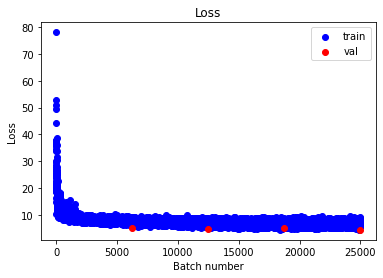

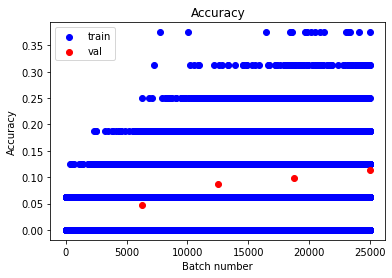

epoch: 3


KeyboardInterrupt: ignored

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

Уменьшаю lr до 0.01 потому что начинает колебаться лосс, но тест растет и шедулер не видит проблем

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
n_epochs = 30

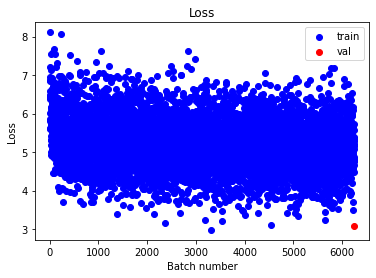

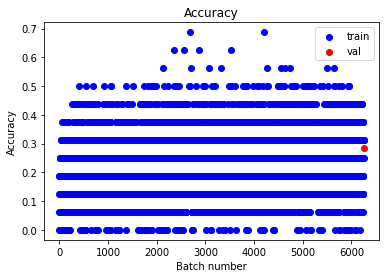

epoch: 0


KeyboardInterrupt: ignored

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

Аналогичная проблема, понижаю до 0.001 после окончания эпохи 

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
n_epochs = 10

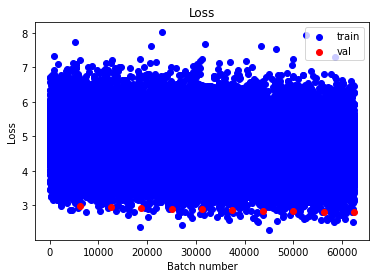

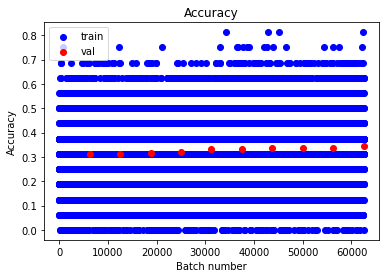

epoch: 9
Inception Training done
Vall loss: 2.7965440844535827 
Vall accuracy: 0.3448


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

Вот тут кончились эпохи, kernel умер, подгружаю модель

In [ ]:
model = Resnet()

In [ ]:
model.load_state_dict(torch.load('checkpoint.pt'))

<All keys matched successfully>

In [ ]:
model = model.to('cuda:0')

In [ ]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = ImageFolder("./dataset/dataset/train", transform=transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)

Loss оставляю 1 + 0.2 + 0.3, учу слои только для первого предикта

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
for param in list(model.parameters())[:70]:
    param.requires_grad = True

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
n_epochs = 10

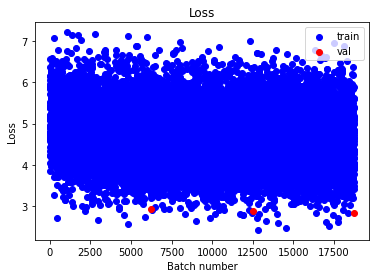

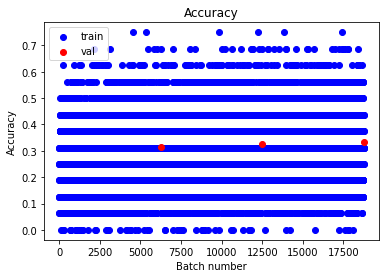

epoch: 2


Train loss: 4.580670894145966
Train loss: 4.592982709407806
Train loss: 4.585425680160522
Train loss: 4.584720345020294
Train loss: 4.599199460983276
Train loss: 4.597561784744263
Train loss: 4.582521055221558
Train loss: 4.58664482498169
Train loss: 4.597807267189026
Train loss: 4.584366517543793
Train loss: 4.608689974308014
Train loss: 4.602264142513275
Train loss: 4.605184375762939
Train loss: 4.62183023262024
Train loss: 4.6198764100074765
Train loss: 4.595054517745972
Train loss: 4.615806393623352
Train loss: 4.622711136341095
Train loss: 4.622033923149109
Train loss: 4.618585481643676
Train loss: 4.636264209270477


KeyboardInterrupt: ignored

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

Еще 10 эпох только первые слои с лр = 1е-4 и потом 20 эпох начиная с лр=1е-3 всю сеть пока куда хорошая

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
n_epochs = 10

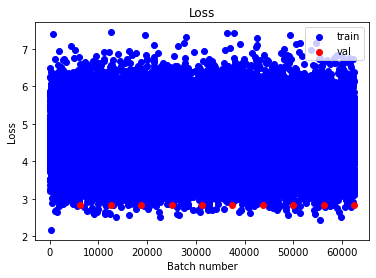

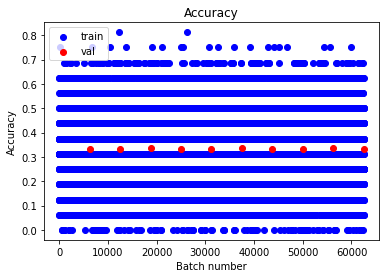

epoch: 9
Inception Training done
Vall loss: 2.831352763080597 
Vall accuracy: 0.3343


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

In [ ]:
for param in model.parameters():
    param.requires_grad = True

In [ ]:
 torch.save(model.state_dict(), 'checkpoint1.pt')
 files.download('checkpoint1.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)
n_epochs = 20

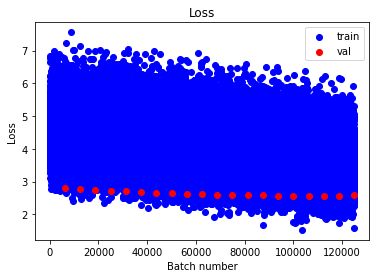

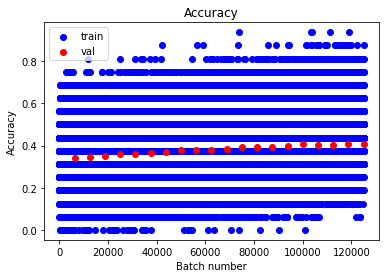

epoch: 19
Inception Training done
Vall loss: 2.576322103643417 
Vall accuracy: 0.4059


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

In [ ]:
 torch.save(model.state_dict(), 'checkpoint1.pt')
 files.download('checkpoint1.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Поднимаю лосс до 1, 0.3, 0.3 (раньше было 1, 0.2, 0.3), ставлю lr = 1e-2 и начинаю учить еще 30 эпох, нужен прорыв

In [ ]:
model = Resnet()
model.load_state_dict(torch.load('checkpoint1 (1).pt'))
model = model.to('cuda:0')

In [ ]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")


transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = ImageFolder("./dataset/dataset/train", transform=transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
n_epochs = 30

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

In [ ]:
 torch.save(model.state_dict(), 'checkpoint2.pt')
 files.download('checkpoint2.pt')

NameError: ignored

Перехожу к лоссу только от выхода, lr=1e-2

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
n_epochs = 30

NameError: ignored

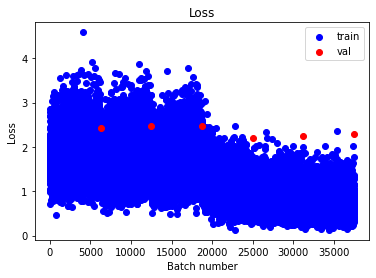

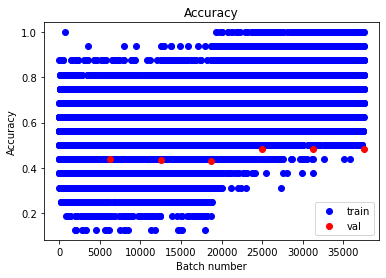

epoch: 5


Train loss: 0.7507558472156525


KeyboardInterrupt: ignored

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

Стоп, переобучилось

In [ ]:
torch.save(model.state_dict(), 'checkpoint3.pt')

Аугментации? - научилось от 0.477 до 0.512, checkpoint3 => checkpoint4, график потерялся 

Добавил в трансформы рэндом кроп 55 * 55 посмотреть че будет

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.RandomVerticalFlip(p=0.3),
                                      transforms.RandomRotation(15),
                                      transforms.RandomErasing(p=0.3, scale=(0.1, 0.3)),
                                      transforms.RandomCrop(55, pad_if_needed=True, fill=0),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
n_epochs = 30

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

Train loss: 2.318419657945633
Train loss: 2.3649473083019257
Train loss: 2.346722135146459
Train loss: 2.3600209441781046
Train loss: 2.3751739276647568
Train loss: 2.4040145136117936
Train loss: 2.3865270680189132
Train loss: 2.4185510317087173
Train loss: 2.412052181363106
Train loss: 2.392746428966522
Train loss: 2.383697356462479
Train loss: 2.388065748214722
Train loss: 2.377969913721085
Train loss: 2.3689782257080076
Train loss: 2.377380954504013
Train loss: 2.3864970092773437
Train loss: 2.393726710796356
Train loss: 2.3820913684368135
Train loss: 2.3896875025033952
Train loss: 2.385469887852669
Train loss: 2.3655649448633196
Train loss: 2.3570903149843216
Train loss: 2.375522546648979
Train loss: 2.3860653154850007
Train loss: 2.4016241397857665
Train loss: 2.41766139626503
Train loss: 2.4232331681251527
Train loss: 2.4060085697174074
Train loss: 2.3964820561408997
Train loss: 2.3868870396614073
Train loss: 2.366437780857086
Train loss: 2.3666304099559783
Train loss: 2.35998783

Вот тут продолжается обучение 

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_transform = transform
train_dataset = ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = Resnet()
model = model.to('cuda:0')

In [ ]:
model.load_state_dict(torch.load('checkpoint4.pt'))

<All keys matched successfully>

Начальное качество - 0.5123, попробую в лоб просто поучить на лосс только на выходе, lr=1e-3. Идея отстой, только переобучается и тест совершенно не растет, попробую еще раз с аугментациями.

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.RandomVerticalFlip(p=0.3),
                                      transforms.RandomRotation(15),
                                      transforms.RandomErasing(p=0.3, scale=(0.1, 0.3)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = Resnet()
model.load_state_dict(torch.load('checkpoint4.pt'))
model = model.to('cuda:0')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0.0001, nesterov=False)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
n_epochs = 30

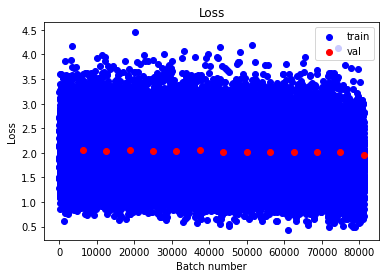

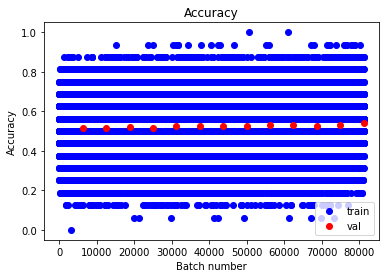

epoch: 12


Train loss: 1.7550849384069442


KeyboardInterrupt: ignored

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.0001, nesterov=False)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, verbose=True)
n_epochs = 30

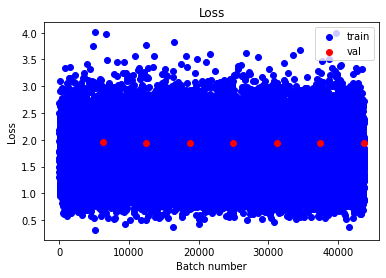

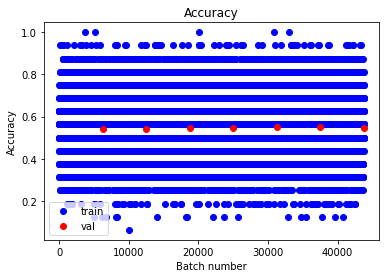

epoch: 6


Train loss: 1.667923230290413
Train loss: 1.6770464094877242
Train loss: 1.665051567554474
Train loss: 1.6671857395172118
Train loss: 1.6702162736654282


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

# !!!

Учу с checkpoint2 с аугментациями 

In [ ]:
train_transform = transforms.Compose([transforms.ToTensor(), 
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.RandomVerticalFlip(p=0.3),
                                      transforms.RandomRotation(15),
                                      transforms.RandomErasing(p=0.3, scale=(0.1, 0.3)),
                                      transforms.RandomPerspective(p=0.3, fill=0),
                                      transforms.RandomColo
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
train_dataset = ImageFolder("./dataset/dataset/train", transform=train_transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=16,
                                           shuffle=True,
                                           num_workers=2)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=16,
                                           shuffle=False,
                                           num_workers=1)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
model = Resnet()
model.load_state_dict(torch.load('/content/drive/My Drive/Deep Learning/checkpoint2.pt'))
model = model.to('cuda:0')

In [ ]:
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9, weight_decay=0.0001, nesterov=True)
scheduler =  torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
n_epochs = 40

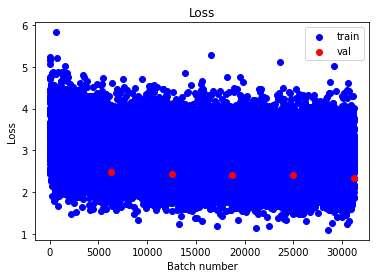

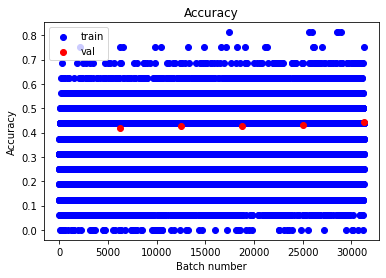

epoch: 4
Last val loss: 2.3365955844402313, best val loss: 2.3365955844402313
Last val acc: 0.4454, best val acc: 0.4454


/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")
/usr/local/lib/python3.6/dist-packages/torchvision/transforms/functional_tensor.py:876: UserWarning: Argument fill/fillcolor is not supported for Tensor input. Fill value is zero
  warnings.warn("Argument fill/fillcolor is not supported for Tensor input. Fill value is zero")


Train loss: 2.7780420756340027
Train loss: 2.7606816103458405
Train loss: 2.7585564062595367
Train loss: 2.733119314432144
Train loss: 2.7210804352760314
Train loss: 2.727303406715393
Train loss: 2.736314448595047
Train loss: 2.7225151243209837
Train loss: 2.7241560964584353
Train loss: 2.70892645072937
Train loss: 2.709100879192352
Train loss: 2.686981380224228
Train loss: 2.7066238169670105
Train loss: 2.704896371603012
Train loss: 2.7408368973731996
Train loss: 2.740001321077347
Train loss: 2.7448269052505494
Train loss: 2.734109126329422
Buffered data was truncated after reaching the output size limit.

In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler, 'Inception', batch_size=3125*2)

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print(accuracy)


0.4269


#### Pretrained Resnet50

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize((224, 224)),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                                     ])


train_dataset = ImageFolder("./dataset/dataset/train", transform=transform)
val_dataset = ImageFolder("./dataset/dataset/val", transform=transform)

In [ ]:
train_dataloader = DataLoader(dataset=train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=1)
val_dataloader = DataLoader(dataset=val_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [ ]:
model = models.resnet50(pretrained=True)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Sequential(nn.Dropout(p=0.5), nn.Linear(2048, 200))

In [ ]:
optimizer = torch.optim.Adam(model.fc.parameters())
scheduler = None 

In [ ]:
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda:0')
n_epochs=1

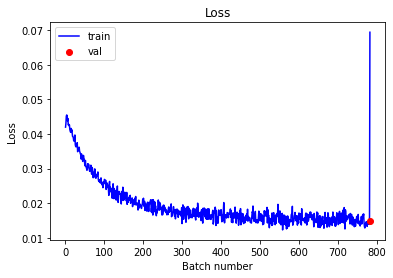

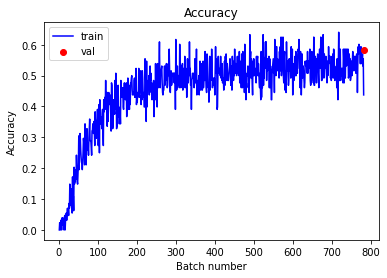

epoch: 0
REsnet Training done
Vall loss: 0.014712603680223604 
Vall accuracy: 0.5836


In [ ]:
train(model, train_dataloader, val_dataloader, criterion, optimizer, device, n_epochs, scheduler=scheduler, batch_size=782, id='REsnet')

#### После всех экспериментов которые вы проделали, выберите лучшую из своих моделей, запустите функцию evaluate. Эта функция должна брать на вход модель и даталоадер с валидационными данными и возврашать accuracy, посчитанную на этом датасете.

In [ ]:
all_losses, predicted_labels, true_labels = predict(model, val_dataloader, criterion, device)
assert len(predicted_labels) == len(val_dataset)
accuracy = accuracy_score(true_labels, predicted_labels)
print("Оценка за это задание составит {} баллов".format(min(5, 5*accuracy / 0.44)))


Оценка за это задание составит 5 баллов


__Ваш отчёт о проделанных экспериментах__: 

1.  Inception учится безумно медленно и надо очень много эпох для улучшения качества
2.  Пытаться обучать модели с нуля когда предлагается найти решение с обучением 15 минут - плохая идея
3.  Надо смотреть на входные требования предобученных моделей - обучается гораздо лучше и быстрее
4.  Данных много но не достаточно для того чтобы предобученная модель обучением одного слоя не достигла качества необходимого для получения 10 за бонусную часть



## Часть 2. Object detection.

В этом задании потребуется обучить детектор фруктов на изображении. Датасет можно скачать [отсюда](https://yadi.sk/d/UPwQB7OZrB48qQ).

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Deep Learning/archive.zip'

In [ ]:
# we will need this library to process the labeling
! pip install xmltodict

In [ ]:
! pip install --upgrade albumentations

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import xmltodict
import json
import glob
import cv2
import os
import torchvision
import matplotlib.pyplot as plt
from sklearn.metrics import auc
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import models
from torchvision import transforms
from IPython.display import display, clear_output
from albumentations.pytorch import ToTensorV2, ToTensor

Выпишем кое-какую техническую работу, которая уже была на семинаре.

In [ ]:
def intersection_over_union(dt_bbox, gt_bbox):
    """
    Intersection over Union between two bboxes
    :param dt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :param gt_bbox: list or numpy array of size (4,) [x0, y0, x1, y1]
    :return : intersection over union
    """

    ## TODO YOUR CODE

    intersection_bbox = np.array(
        [
            max(dt_bbox[0], gt_bbox[0]),
            max(dt_bbox[1], gt_bbox[1]),
            min(dt_bbox[2], gt_bbox[2]),
            min(dt_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (dt_bbox[2] - dt_bbox[0]) * (dt_bbox[3] - dt_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

def evaluate_sample(target_pred, target_true, iou_threshold=0.5):
    gt_bboxes = target_true["boxes"].numpy()
    gt_labels = target_true["labels"].numpy()

    dt_bboxes = target_pred["boxes"].numpy()
    dt_labels = target_pred["labels"].numpy()
    dt_scores = target_pred["scores"].numpy()

    results = []
    for detection_id in range(len(dt_labels)):
        dt_bbox = dt_bboxes[detection_id, :]
        dt_label = dt_labels[detection_id]
        dt_score = dt_scores[detection_id]

        detection_result_dict = {"score": dt_score}

        max_IoU = 0
        max_gt_id = -1
        for gt_id in range(len(gt_labels)):
            gt_bbox = gt_bboxes[gt_id, :]
            gt_label = gt_labels[gt_id]

            if gt_label != dt_label:
                continue

            if intersection_over_union(dt_bbox, gt_bbox) > max_IoU:
                max_IoU = intersection_over_union(dt_bbox, gt_bbox)
                max_gt_id = gt_id

        if max_gt_id >= 0 and max_IoU >= iou_threshold:
            detection_result_dict["TP"] = 1
            gt_labels = np.delete(gt_labels, max_gt_id, axis=0)
            gt_bboxes = np.delete(gt_bboxes, max_gt_id, axis=0)

        else:
            detection_result_dict["TP"] = 0

        results.append(detection_result_dict)

    return results


def evaluate(model, test_loader, device):
    results = []
    model.eval()
    nbr_boxes = 0
    with torch.no_grad():
        for batch, (images, targets_true) in enumerate(test_loader):
            images = list(image.to(device).float() for image in images)
            targets_pred = model(images)
            targets_true = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_true
            ]
            targets_pred = [
                {k: v.cpu().float() for k, v in t.items()} for t in targets_pred
            ]

            for i in range(len(targets_true)):
                target_true = targets_true[i]
                target_pred = targets_pred[i]
                nbr_boxes += target_true["labels"].shape[0]

                results.extend(evaluate_sample(target_pred, target_true))

    results = sorted(results, key=lambda k: k["score"], reverse=True)

    acc_TP = np.zeros(len(results))
    acc_FP = np.zeros(len(results))
    recall = np.zeros(len(results))
    precision = np.zeros(len(results))

    if results[0]["TP"] == 1:
        acc_TP[0] = 1
    else:
        acc_FP[0] = 1

    for i in range(1, len(results)):
        acc_TP[i] = results[i]["TP"] + acc_TP[i - 1]
        acc_FP[i] = (1 - results[i]["TP"]) + acc_FP[i - 1]

        precision[i] = acc_TP[i] / (acc_TP[i] + acc_FP[i])
        recall[i] = acc_TP[i] / nbr_boxes

    return auc(recall, precision)

Датасет мы за вас написали.

In [ ]:
# add any imports you need

class2tag = {"apple": 1, "orange": 2, "banana": 3}


class FruitDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.images = []
        self.annotations = []
        self.transform = transform
        for annotation in glob.glob(data_dir + "/*xml"):
            image_fname = os.path.splitext(annotation)[0] + ".jpg"
            self.images.append(cv2.cvtColor(cv2.imread(image_fname), cv2.COLOR_BGR2RGB))
            with open(annotation) as f:
                annotation_dict = xmltodict.parse(f.read())
            bboxes = []
            labels = []
            objects = annotation_dict["annotation"]["object"]
            if not isinstance(objects, list):
                objects = [objects]
            for obj in objects:
                bndbox = obj["bndbox"]
                bbox = [bndbox["xmin"], bndbox["ymin"], bndbox["xmax"], bndbox["ymax"]]
                bbox = list(map(int, bbox))
                bboxes.append(torch.tensor(bbox))
                labels.append(class2tag[obj["name"]])
            self.annotations.append(
                {"boxes": torch.stack(bboxes).float(), "labels": torch.tensor(labels)}
            )

    def __getitem__(self, i):
        if self.transform:
            # the following code is correct if you use albumentations
            # if you use torchvision transforms you have to modify it =)
            res = self.transform(
                image=self.images[i],
                bboxes=self.annotations[i]["boxes"],
                labels=self.annotations[i]["labels"]
            )
            return res["image"], {
                "boxes": torch.tensor(res["bboxes"]),
                "labels": torch.tensor(res["labels"]),
            }
        else:
            return self.images[i], self.annotations[i]

    def __len__(self):
        return len(self.images)

Вам мы оставляем творческую часть =)

__Задание__. Обучите модель для object detection на __обучающем__ датасете и добейтесь PR-AUC не менее __0.91__ на  __тестовом__.

 - Создайте модель и оптимайзер
 - Напишите функцию обучения модели
 - Используйте аугментации
 
Использовать аугментации для обучения __обязательно__. Они дадут 1 балл из 5. Пользуйтесь модулем torchvision.transforms или библиотекой albumentations (о которой говорилось ранее). Последняя библиотека особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Советуем обратить внимание на следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). Обратите внимание, что код, написанный в датасете выше, верен только если вы используете albumentations. Если вы выбрали путь torchvision.transforms, вам потребуется метод `__getitem__` изменить (что-то типа `return self.transform(self.images[i])`; однако в таком случае вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную =))

Оставшиеся 4 балла вычисляются по простой формуле: __min(4, 4 * Ваш auc / 0.91)__.

[Аугментации](https://medium.com/@lessw/state-of-the-art-object-detection-use-these-top-3-data-augmentations-and-google-brains-optimal-57ac6d8d1de5) - полный провал

Код для early stopping позаимствован [тут](https://github.com/Bjarten/early-stopping-pytorch), используется как готовый класс, но скопирован для удобства вызова функции - пипом не ставится:(

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

Вдохновление для функции: sem07, также известный как [цикл от pytorch](https://github.com/pytorch/vision/blob/master/references/detection/engine.py)

In [ ]:
def train_one_epoch(model, train_dataloader, optimizer, device):
    acc_loss = 0
    n = 0
    for images, targets in tqdm(train_dataloader):
        images = list(image.to(device).float() for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        dict_loss = model(images, targets)
        losses = sum(loss for loss in dict_loss.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        n += 1
        

        acc_loss += losses.item()

        if n % 10 == 0:
            print(f'Mean loss = {acc_loss/n}')
          
def train(model, train_dataloader, val_dataloader, optimizer, device, scheduler = None, n_epochs=10):
    model = model.to(device)
    early_stopping = EarlyStopping(patience=20, verbose=True)
    for epoch in range(n_epochs):
        model.train()
        train_one_epoch(model, train_dataloader, optimizer, device=device)
        model.eval()
        a = evaluate(model, val_dataloader, device=device)
        print(f"AUC ON TEST: {round(a, 4)}, Epoch: {epoch}")
        if scheduler:
            scheduler.step(a)

        early_stopping(-a, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

In [ ]:
def collate_fn(batch): #sem07
    return tuple(zip(*batch))

In [ ]:
train_transform = A.Compose([A.OneOf([A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.Rotate(180, p=1), A.Flip(p=1)
], p=0.5), ToTensor()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
val_transform = A.Compose([ToTensor()], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

In [ ]:
train_dataset = FruitDataset("./train_zip/train", transform=train_transform)
val_dataset = FruitDataset("./test_zip/test", transform=val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, collate_fn=collate_fn)

In [ ]:
torch.manual_seed(6)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.roi_heads.box_predictor = FastRCNNPredictor(1024, 4)
model = model.to('cuda:0')
device= torch.device('cuda:0')
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=1, verbose=True)

In [ ]:
train(model, train_dataloader, val_dataloader, optimizer, device, n_epochs=40, scheduler=scheduler)

Mean loss = 1.029435429435765
Mean loss = 0.7842869468086611
Mean loss = 0.6706729056666667
Mean loss = 0.6226844103190634
Mean loss = 0.5860724721747473
Mean loss = 0.5591728968246059
Mean loss = 0.5407949667439412
Mean loss = 0.5240185867016988
Mean loss = 0.5313192948220865
Mean loss = 0.5096553022428989
Mean loss = 0.5016025851653961
Mean loss = 0.4920916727477698



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


AUC ON TEST: 0.1724, Epoch: 0
Validation loss decreased (inf --> -0.172352).  Saving model ...


Mean loss = 0.42046381207613753
Mean loss = 0.39088731301445756
Mean loss = 0.3977306241449232
Mean loss = 0.40004339054465465
Mean loss = 0.3901076751645533
Mean loss = 0.40169441604925554
Mean loss = 0.39008348554546335
Mean loss = 0.3893825320385568
Mean loss = 0.3877137258404215
Mean loss = 0.38583782824055207
Mean loss = 0.38010115563206526
Mean loss = 0.3711705999156811

AUC ON TEST: 0.3498, Epoch: 1
Validation loss decreased (-0.172352 --> -0.349767).  Saving model ...


Mean loss = 0.2783102613335849
Mean loss = 0.2761504080968037
Mean loss = 0.31479655341343815
Mean loss = 0.3203682015597755
Mean loss = 0.30331358097760136
Mean loss = 0.3114018615718963
Mean loss = 0.30417972607256666
Mean loss = 0.30109470879863676
Mean loss = 0.2906566544118158
Mean loss = 0.2984741276646602
Mean loss = 0.36020638966025087
Mean loss = 0.3470322728771542

AUC ON TEST: 0.6073, Epoch: 2
Validation loss decreased (-0.349767 --> -0.607288).  Saving model ...


Mean loss = 0.30763733971705154
Mean loss = 0.27739781664084645
Mean loss = 0.26233748198586476
Mean loss = 0.23805267558122617
Mean loss = 0.2542240791811834
Mean loss = 0.26362472477587157
Mean loss = 0.258621377389754
Mean loss = 0.257693393858043
Mean loss = 0.25721535231539144
Mean loss = 0.2512304954714099
Mean loss = 0.2479799156057404
Mean loss = 0.25219576999027604

AUC ON TEST: 0.6395, Epoch: 3
Validation loss decreased (-0.607288 --> -0.639470).  Saving model ...


Mean loss = 0.26648515641604126
Mean loss = 0.26666062316107614
Mean loss = 0.23322887569718284
Mean loss = 0.21891295715843756
Mean loss = 0.23511717204480895
Mean loss = 0.2350892969028812
Mean loss = 0.22931784687872409
Mean loss = 0.22546642229522607
Mean loss = 0.22855109415916144
Mean loss = 0.23291925404605526
Mean loss = 0.22412270624878167
Mean loss = 0.22043702209261232

AUC ON TEST: 0.7062, Epoch: 4
Validation loss decreased (-0.639470 --> -0.706248).  Saving model ...


Mean loss = 0.2300746674605322
Mean loss = 0.2396443655988286
Mean loss = 0.219595379345587
Mean loss = 0.21322803729621148
Mean loss = 0.21196755055623362
Mean loss = 0.2219903002403138
Mean loss = 0.21719285071966038
Mean loss = 0.2134271474447654
Mean loss = 0.21142309050578328
Mean loss = 0.2162585033176354
Mean loss = 0.21661847742194895
Mean loss = 0.21630127146536537

AUC ON TEST: 0.7784, Epoch: 5
Validation loss decreased (-0.706248 --> -0.778440).  Saving model ...


Mean loss = 0.20025167983138234
Mean loss = 0.195849479921059
Mean loss = 0.20185053681780382
Mean loss = 0.18926383035561076
Mean loss = 0.19522195362889697
Mean loss = 0.19207509399540434
Mean loss = 0.19672214136431074
Mean loss = 0.1970176528966646
Mean loss = 0.20112672699282197
Mean loss = 0.19709448731337256
Mean loss = 0.20112035755491084
Mean loss = 0.1996184605723604

AUC ON TEST: 0.8592, Epoch: 6
Validation loss decreased (-0.778440 --> -0.859239).  Saving model ...


Mean loss = 0.18262008685072964
Mean loss = 0.15695952579516292
Mean loss = 0.16438853803183442
Mean loss = 0.1709374215990061
Mean loss = 0.17257791303858386
Mean loss = 0.16965993626436046
Mean loss = 0.17692934989023504
Mean loss = 0.17685120863414436
Mean loss = 0.18026011605419484
Mean loss = 0.18280355882309082
Mean loss = 0.18147450970466308
Mean loss = 0.18817346630759876

AUC ON TEST: 0.8055, Epoch: 7
EarlyStopping counter: 1 out of 20


Mean loss = 0.19817742529410887
Mean loss = 0.19857094910944204
Mean loss = 0.18098030191444645
Mean loss = 0.17752768348280368
Mean loss = 0.174937196831518
Mean loss = 0.18291871933735093
Mean loss = 0.18128569371298828
Mean loss = 0.1748315236520071
Mean loss = 0.17665852550020983
Mean loss = 0.1813761422207228
Mean loss = 0.1819248230061597
Mean loss = 0.1805796728244706

AUC ON TEST: 0.8803, Epoch: 8
Validation loss decreased (-0.859239 --> -0.880290).  Saving model ...


Mean loss = 0.20560678074939878
Mean loss = 0.18858603346868918
Mean loss = 0.17711342308168473
Mean loss = 0.1779542287808811
Mean loss = 0.17139450003945125
Mean loss = 0.1733453571981989
Mean loss = 0.1680701744849613
Mean loss = 0.17291466604122366
Mean loss = 0.17253830271893636
Mean loss = 0.17085456850872002
Mean loss = 0.1737461885570574
Mean loss = 0.17097439028867295

AUC ON TEST: 0.8717, Epoch: 9
EarlyStopping counter: 1 out of 20


Mean loss = 0.14378103134440698
Mean loss = 0.15802386406824287
Mean loss = 0.1593520644578606
Mean loss = 0.14919641245335163
Mean loss = 0.17385308263653912
Mean loss = 0.17429429203529162
Mean loss = 0.17565121941732845
Mean loss = 0.17672333056753517
Mean loss = 0.1778870999385993
Mean loss = 0.17720537857740315
Mean loss = 0.1754873804126126
Mean loss = 0.1736689097720832

AUC ON TEST: 0.9152, Epoch: 10
Validation loss decreased (-0.880290 --> -0.915187).  Saving model ...


Mean loss = 0.12007763352584214
Mean loss = 0.14173303903028317
Mean loss = 0.13282194277260892
Mean loss = 0.13786375134484835
Mean loss = 0.14896400203997012
Mean loss = 0.1482648315679876
Mean loss = 0.1544236421818043
Mean loss = 0.15942888512049197
Mean loss = 0.15837201138542628
Mean loss = 0.15485144048199298
Mean loss = 0.15232707846337035
Mean loss = 0.15559070096385133

AUC ON TEST: 0.8835, Epoch: 11
EarlyStopping counter: 1 out of 20


Mean loss = 0.1407885731255996
Mean loss = 0.16623856662977674
Mean loss = 0.15706899700493343
Mean loss = 0.15077028322422303
Mean loss = 0.14808330493512106
Mean loss = 0.15583480805694963
Mean loss = 0.1620472683439932
Mean loss = 0.15884894253005055
Mean loss = 0.1578126540820368
Mean loss = 0.15999720680087426
Mean loss = 0.15855600253914448
Mean loss = 0.15994186627348717

AUC ON TEST: 0.8889, Epoch: 12
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
EarlyStopping counter: 2 out of 20


Mean loss = 0.11313206521358807
Mean loss = 0.12173529148104123
Mean loss = 0.11928791774451092
Mean loss = 0.13256351141211636
Mean loss = 0.1348103297110994
Mean loss = 0.1412931032833122
Mean loss = 0.13367499931100751
Mean loss = 0.13883371402875982
Mean loss = 0.14300864907022245
Mean loss = 0.13952607093362124
Mean loss = 0.1430103284885201
Mean loss = 0.1409241229488999

AUC ON TEST: 0.9245, Epoch: 13
Validation loss decreased (-0.915187 --> -0.924540).  Saving model ...


Mean loss = 0.16002473528244493
Mean loss = 0.15638528238548452
Mean loss = 0.1305294288247219
Mean loss = 0.13759302949197724
Mean loss = 0.13494725901931065
Mean loss = 0.14111820297944344
Mean loss = 0.14536479373502417
Mean loss = 0.14297441014744103
Mean loss = 0.1405495117038791
Mean loss = 0.14148321079421167
Mean loss = 0.14106621747219036
Mean loss = 0.13987911457946242

AUC ON TEST: 0.925, Epoch: 14
Validation loss decreased (-0.924540 --> -0.925050).  Saving model ...


Mean loss = 0.121352921846374
Mean loss = 0.11420970887230406
Mean loss = 0.11733633021032357
Mean loss = 0.1189698118641707
Mean loss = 0.12364898869877418
Mean loss = 0.1364637049443676
Mean loss = 0.13367967245138565
Mean loss = 0.1303365663457334
Mean loss = 0.13041473990132424
Mean loss = 0.12797082023816395
Mean loss = 0.13386627294451783
Mean loss = 0.13144494361784517

AUC ON TEST: 0.9224, Epoch: 15
EarlyStopping counter: 1 out of 20


Mean loss = 0.1677796454326977
Mean loss = 0.13795023199695883
Mean loss = 0.15475657017319494
Mean loss = 0.1504723837226734
Mean loss = 0.1448129548252399
Mean loss = 0.14498302069822655
Mean loss = 0.14188729525923124
Mean loss = 0.13840653013227927
Mean loss = 0.14025763132850308
Mean loss = 0.13947131852265254
Mean loss = 0.13836145524493468
Mean loss = 0.1365076087863797

AUC ON TEST: 0.9182, Epoch: 16
Epoch    17: reducing learning rate of group 0 to 1.0000e-05.
EarlyStopping counter: 2 out of 20


Mean loss = 0.1275754092690065
Mean loss = 0.13529602584017153
Mean loss = 0.13791051440622729
Mean loss = 0.13549671705732166
Mean loss = 0.13237425448336876
Mean loss = 0.12485842624753317
Mean loss = 0.126008971099474
Mean loss = 0.1261759690426975
Mean loss = 0.12307727756544781
Mean loss = 0.12535691871283972
Mean loss = 0.12760324410547758
Mean loss = 0.1288020878287004

AUC ON TEST: 0.919, Epoch: 17
EarlyStopping counter: 3 out of 20


Mean loss = 0.10598564491656552
Mean loss = 0.10144819498244387
Mean loss = 0.1024172832106766
Mean loss = 0.10943280103497002
Mean loss = 0.11246700786575436
Mean loss = 0.12082060295380483
Mean loss = 0.12699730782438096
Mean loss = 0.12436570098842807
Mean loss = 0.12594365013095477
Mean loss = 0.12737122721384309
Mean loss = 0.12787402929228386
Mean loss = 0.12685600198039704

AUC ON TEST: 0.9195, Epoch: 18
Epoch    19: reducing learning rate of group 0 to 1.0000e-06.
EarlyStopping counter: 4 out of 20


Mean loss = 0.17319348189182543
Mean loss = 0.14071541384231442
Mean loss = 0.1488374543631606
Mean loss = 0.14903328750641007
Mean loss = 0.15685671306441104
Mean loss = 0.15696594561807323
Mean loss = 0.1509066898976
Mean loss = 0.14822158676198754
Mean loss = 0.14374486861595206
Mean loss = 0.14298824037633906
Mean loss = 0.13925413092198066
Mean loss = 0.13585885543429785

AUC ON TEST: 0.9282, Epoch: 19
Validation loss decreased (-0.925050 --> -0.928240).  Saving model ...


Mean loss = 0.15623603188974214
Mean loss = 0.1365870535206041
Mean loss = 0.12154670167622823
Mean loss = 0.12021102308053344
Mean loss = 0.12208085183018376
Mean loss = 0.1189277144510782
Mean loss = 0.124710785709878
Mean loss = 0.1341790586825305
Mean loss = 0.1338584494973758
Mean loss = 0.13577158475339082
Mean loss = 0.13813561722766696
Mean loss = 0.13545854978717162

AUC ON TEST: 0.9198, Epoch: 20
EarlyStopping counter: 1 out of 20


Mean loss = 0.10718596147046933
Mean loss = 0.12774020331552305
Mean loss = 0.11149558563039025
Mean loss = 0.11857925582089039
Mean loss = 0.11973379233909624
Mean loss = 0.11544515752680597
Mean loss = 0.12265276098590895
Mean loss = 0.12259497314234798
Mean loss = 0.12307873364941345
Mean loss = 0.12466396732133134
Mean loss = 0.12255547525207222
Mean loss = 0.1254458009447289

AUC ON TEST: 0.9198, Epoch: 21
Epoch    22: reducing learning rate of group 0 to 1.0000e-07.
EarlyStopping counter: 2 out of 20


Mean loss = 0.1147688874871654
Mean loss = 0.1314533882821081
Mean loss = 0.1311406685560576
Mean loss = 0.13124059096726196
Mean loss = 0.12468943282774089
Mean loss = 0.12138202187841989
Mean loss = 0.12326686173129289
Mean loss = 0.12832840919348112
Mean loss = 0.13287711518777698
Mean loss = 0.12730259643982403
Mean loss = 0.1285754659225936
Mean loss = 0.13160364418096024

AUC ON TEST: 0.9198, Epoch: 22
EarlyStopping counter: 3 out of 20


Mean loss = 0.11944602373055364
Mean loss = 0.12984894615646597
Mean loss = 0.1243317625343751
Mean loss = 0.1356399781527742
Mean loss = 0.14897791937889343
Mean loss = 0.1383420625918347
Mean loss = 0.13609069712433877
Mean loss = 0.13300021326724606
Mean loss = 0.13767668646924483
Mean loss = 0.13333642617782415
Mean loss = 0.17244647214686237
Mean loss = 0.17152391899578287

AUC ON TEST: 0.9197, Epoch: 23
Epoch    24: reducing learning rate of group 0 to 1.0000e-08.
EarlyStopping counter: 4 out of 20


Mean loss = 0.13465114954770604
Mean loss = 0.11818985555386044
Mean loss = 0.11811770911144014
Mean loss = 0.11889685728044967
Mean loss = 0.12042440227677453
Mean loss = 0.12999859793124743
Mean loss = 0.12999032325163062
Mean loss = 0.13515759172804725
Mean loss = 0.13465562789584246
Mean loss = 0.13316999105139038
Mean loss = 0.13040025468367472
Mean loss = 0.12710132946642685

AUC ON TEST: 0.9197, Epoch: 24
EarlyStopping counter: 5 out of 20


Mean loss = 0.10843196252424388
Mean loss = 0.11217082414132676
Mean loss = 0.11581528117461247
Mean loss = 0.12561478675574592
Mean loss = 0.12081235328110111
Mean loss = 0.1186298240408218
Mean loss = 0.11476867815283402
Mean loss = 0.12037033755573348
Mean loss = 0.12117369303566136
Mean loss = 0.12582857138271375
Mean loss = 0.12368960397435728
Mean loss = 0.12822173499895223

AUC ON TEST: 0.9197, Epoch: 25
EarlyStopping counter: 6 out of 20


Mean loss = 0.1733609267448329
Mean loss = 0.16982197191965043
Mean loss = 0.17242325458561827
Mean loss = 0.1595790395346027
Mean loss = 0.1513433570844663
Mean loss = 0.14122391607121954
Mean loss = 0.1399132865322212
Mean loss = 0.1409078931009921
Mean loss = 0.1383544144049692
Mean loss = 0.13902313628546184
Mean loss = 0.1395127500537424
Mean loss = 0.13961341653038756

AUC ON TEST: 0.9197, Epoch: 26
EarlyStopping counter: 7 out of 20


Mean loss = 0.08439610912052616
Mean loss = 0.09454730270682958
Mean loss = 0.11144643006679307
Mean loss = 0.10796008060334583
Mean loss = 0.1256396724028051
Mean loss = 0.12320731831864919
Mean loss = 0.1201417468924087
Mean loss = 0.12429245294778775
Mean loss = 0.12531924507181705
Mean loss = 0.12419210678051472
Mean loss = 0.131209090255714
Mean loss = 0.1301985951856022

AUC ON TEST: 0.9198, Epoch: 27
EarlyStopping counter: 8 out of 20


Mean loss = 0.1383693287827867
Mean loss = 0.11906225627441036
Mean loss = 0.11750500114302766
Mean loss = 0.11976916381162801
Mean loss = 0.12018245378960488
Mean loss = 0.11849798431622457
Mean loss = 0.11438096245032188
Mean loss = 0.11781222265110872
Mean loss = 0.11788784955467695
Mean loss = 0.12480077868065513
Mean loss = 0.12464900087376506
Mean loss = 0.1254529135227957

AUC ON TEST: 0.9198, Epoch: 28
EarlyStopping counter: 9 out of 20


Mean loss = 0.13928535524136923
Mean loss = 0.15526143161867198
Mean loss = 0.14486663665919366
Mean loss = 0.13362696630276205
Mean loss = 0.1343432650191936
Mean loss = 0.13411390744380455
Mean loss = 0.13103885180835104
Mean loss = 0.13026167009075723
Mean loss = 0.13337739089010522
Mean loss = 0.130824009339987
Mean loss = 0.1316916433570549
Mean loss = 0.13126509458004773

AUC ON TEST: 0.9198, Epoch: 29
EarlyStopping counter: 10 out of 20


Mean loss = 0.09362438536343527
Mean loss = 0.09215453892563492
Mean loss = 0.10086904820295109
Mean loss = 0.11174991310896024
Mean loss = 0.12085537140257208
Mean loss = 0.12465361328346061
Mean loss = 0.12601189003856814
Mean loss = 0.1299339168898866
Mean loss = 0.12790536696495236
Mean loss = 0.1270220157428372
Mean loss = 0.12450388303532509
Mean loss = 0.12309038112373748

AUC ON TEST: 0.9198, Epoch: 30
EarlyStopping counter: 11 out of 20


Mean loss = 0.14667942019738084
Mean loss = 0.12823315926539078
Mean loss = 0.1279603218138408
Mean loss = 0.11752427187623096
Mean loss = 0.12534275423597543
Mean loss = 0.12837930636497022
Mean loss = 0.13155662460516798
Mean loss = 0.13089689719332281
Mean loss = 0.13316425412415245
Mean loss = 0.13077372082765254
Mean loss = 0.1332726414110801
Mean loss = 0.12997842975732196

AUC ON TEST: 0.9198, Epoch: 31
EarlyStopping counter: 12 out of 20


Mean loss = 0.146062215784381
Mean loss = 0.11522196387097824
Mean loss = 0.12910796025599294
Mean loss = 0.11664916232539262
Mean loss = 0.11649497832667251
Mean loss = 0.11779219130511684
Mean loss = 0.12269116491632691
Mean loss = 0.120562215711759
Mean loss = 0.12116420797436558
Mean loss = 0.12241747921825995
Mean loss = 0.12645205654090297
Mean loss = 0.1260699950806927

AUC ON TEST: 0.9198, Epoch: 32
EarlyStopping counter: 13 out of 20


Mean loss = 0.17612349107929579
Mean loss = 0.16553346096529906
Mean loss = 0.13917441788257567
Mean loss = 0.13523488639468192
Mean loss = 0.12855258595303695
Mean loss = 0.13033261717371328
Mean loss = 0.13839786504602172
Mean loss = 0.13133493969268212
Mean loss = 0.13110076951922783
Mean loss = 0.12890053874656285
Mean loss = 0.12979645522266256
Mean loss = 0.128841091134075

AUC ON TEST: 0.9198, Epoch: 33
EarlyStopping counter: 14 out of 20


Mean loss = 0.07531294327944539
Mean loss = 0.07991674764272064
Mean loss = 0.0839738589233293
Mean loss = 0.09919112827314674
Mean loss = 0.10948732243359437
Mean loss = 0.11306999982357732
Mean loss = 0.12069850303242123
Mean loss = 0.12256422578635824
Mean loss = 0.12118799367510624
Mean loss = 0.12457334634710467
Mean loss = 0.1348650143256818
Mean loss = 0.1352773204416592

AUC ON TEST: 0.9198, Epoch: 34
EarlyStopping counter: 15 out of 20


Mean loss = 0.08264000200917486
Mean loss = 0.09816661367247581
Mean loss = 0.10281143618194828
Mean loss = 0.1108822680853356
Mean loss = 0.11801025082660851
Mean loss = 0.12371285414365697
Mean loss = 0.12656476453255158
Mean loss = 0.1308809271684957
Mean loss = 0.12916218597886447
Mean loss = 0.1326651308598794
Mean loss = 0.13319475149442525
Mean loss = 0.12945788281163376

AUC ON TEST: 0.9198, Epoch: 35
EarlyStopping counter: 16 out of 20


Mean loss = 0.15553345052162637
Mean loss = 0.1351255718453286
Mean loss = 0.12381267724337598
Mean loss = 0.12311080947873679
Mean loss = 0.12354081071840178
Mean loss = 0.13589597774397993
Mean loss = 0.14336302778930438
Mean loss = 0.13558104888941194
Mean loss = 0.13346336053042687
Mean loss = 0.13155325684756244
Mean loss = 0.13231946668733982
Mean loss = 0.12812993253180316

AUC ON TEST: 0.9198, Epoch: 36
EarlyStopping counter: 17 out of 20


Mean loss = 0.13256564262077258
Mean loss = 0.15083878800526368
Mean loss = 0.1488401701295646
Mean loss = 0.139600890513006
Mean loss = 0.14473138629365587
Mean loss = 0.1373952783032184
Mean loss = 0.1433750938624682
Mean loss = 0.14243671968501084
Mean loss = 0.13693801020014215
Mean loss = 0.1408067204125819
Mean loss = 0.13792549463202664
Mean loss = 0.1373988600749281

AUC ON TEST: 0.9198, Epoch: 37
EarlyStopping counter: 18 out of 20


Mean loss = 0.13779010963330857
Mean loss = 0.13823401953296224
Mean loss = 0.13164702032427825
Mean loss = 0.11590608880899063
Mean loss = 0.10567686335311838
Mean loss = 0.1052893511476239
Mean loss = 0.11398690632702214
Mean loss = 0.12082391924682975
Mean loss = 0.11919407929552112
Mean loss = 0.12085772467411754
Mean loss = 0.12216356770358089
Mean loss = 0.12381571106445034

AUC ON TEST: 0.9198, Epoch: 38
EarlyStopping counter: 19 out of 20


Mean loss = 0.10479408746616489
Mean loss = 0.1207284631298374
Mean loss = 0.131753709253503
Mean loss = 0.12859831151144668
Mean loss = 0.13859339338925047
Mean loss = 0.13680207547158182
Mean loss = 0.14228249523960068
Mean loss = 0.1394480665045371
Mean loss = 0.14111182256746455
Mean loss = 0.13918423796495805
Mean loss = 0.1364788089767538
Mean loss = 0.1330114468214843

AUC ON TEST: 0.9198, Epoch: 39
EarlyStopping counter: 20 out of 20
Early stopping


In [ ]:
model.load_state_dict(torch.load('checkpoint.pt')) #подгружаем модель

<All keys matched successfully>

__Выведите итоговое качество модели__.

In [ ]:
auc = evaluate(model, val_dataloader, device='cuda:0')
print("Оценка за это задание составит {} баллов".format(min(4, 4 * auc / 0.91)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Оценка за это задание составит 4 баллов


Нарисуйте предсказанные bounding box'ы для любых двух картинок из __тестового__ датасета.

In [ ]:
model.eval()
image, labels = val_dataset[8]
pred = model(image.unsqueeze(0).to(device))[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


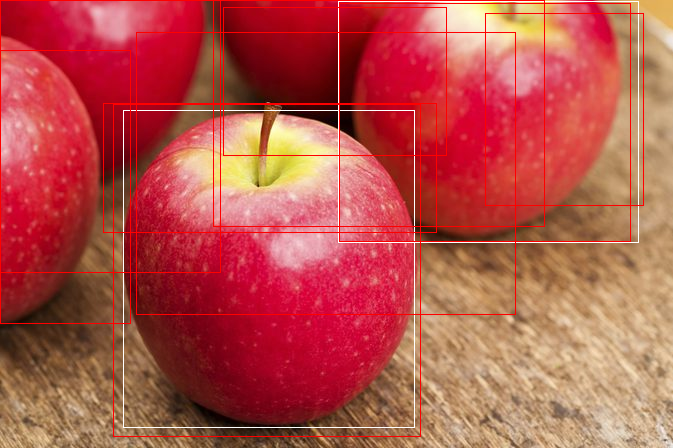

In [ ]:
from PIL import ImageDraw

image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

In [ ]:
model.eval()
image, labels = val_dataset[10]
pred = model(image.unsqueeze(0).to(device))[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


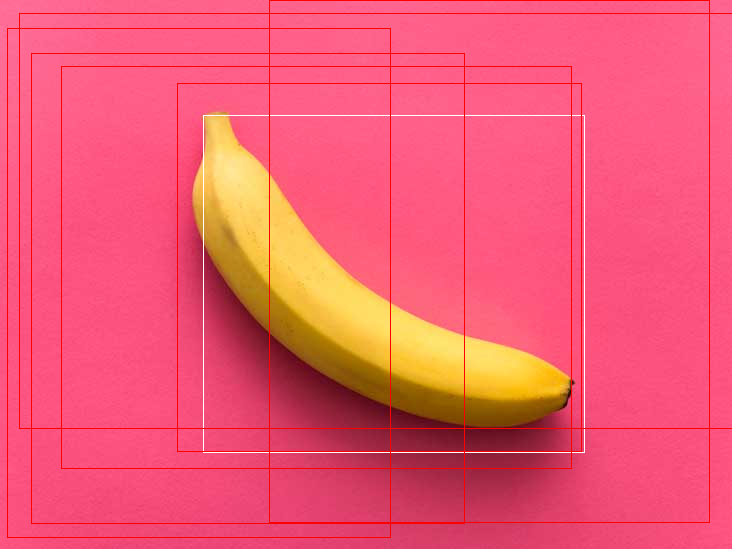

In [ ]:
image = torchvision.transforms.ToPILImage()(image)
draw = ImageDraw.Draw(image)
for box in labels['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])
    
for box in pred['boxes']:
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image

__Ваш отчёт о проделанных экспериментах__: 


1.   Нельзя закидывать очень много рандомных аугментаций
2.   На датасете с фруктами работают только повороты и развороты
3.   Если модель ожидает данные в интервале от 0 до 1, то не надо давать ей картинки с интервалом от 0 до 255 - градиент взрывается и ничего не учится
4.   Качество с аугментациями не очень стабильное - периодически проваливается в локальный максимум по AUC и не хочет из него выходить, добавил early-stopping
5.   Аугментации неожиданно сложно заставить работать, но в итоге AUC увеличилось примерно на 0.01 - 0.018 в зависимости от запуска и случайности аугментаций(без аугментаций fasterrcnn выдает AUC около 0.91)
6.   После введения аугментаций уменьшился минимально достигаемый лосс на тренировочном датасете

## Бонус (10 баллов).

__Задание__. В части с классификацией добейтесь accuracy не менее 0.52. Напишите отчёт о проделанных экспериментах.

__Критерии оценки__. Оценка за бонусную часть равна 10, если вы преодолели качество 0.52 и 0 в противном случае.

__Иных оценок кроме 0 и 10 не предусмотрено__.

В основной части уже больше 0.52

## Бонус (0 баллов).

__Задание 1__. Скиньте ниже смешную картинку, желательно про машинное обучение. На картинке не должно быть никаких упоминаний лектора, семинаристов и ассистентов этого курса.

__Задание 2__. Расскажите, как вам задание? Что понравилось, что не понравилось, что можно улучшить? Мы примем во внимание любой фидбек.